# Google Colaboratory を利用した ieinn ライブラリの使用例
Google Colaboratory(以下 Google Colab)を利用すれば、簡単に Python の実行環境を構築できます. GPU も無料で使用できます. ここでは Google Colab を利用した ieinn ライブラリの使用例を紹介します.
## Google drive をマウントし, ieinn ライブラリを Google drive にダウンロードします。

In [1]:
!git clone https://github.com/AoiHonda-lab/IEI-NeuralNetwork.git
%cd IEI-NeuralNetwork

Cloning into 'IEI-NeuralNetwork'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 168 (delta 28), reused 13 (delta 13), pack-reused 122 (from 1)
Receiving objects: 100% (168/168), 371.40 KiB | 1.41 MiB/s, done.
Resolving deltas: 100% (73/73), done.
/content/IEI-NeuralNetwork


## 必要なライブラリをインポートします

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import csv
from sklearn.model_selection import train_test_split
from ieinn import ieinn

GPUが使える場合は deviceに cuda を設定、そうでなければ cpu を設定します。

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## データの読み込み
データの読み込みと、訓練データと検証データへの分割などの処理をします。

In [4]:
df=pd.read_csv('CarEvaluation.csv',encoding="shift-jis")
df=df.drop(0,axis=0)
df=df.astype(float)

y=pd.DataFrame(df.iloc[:,0])
X=pd.DataFrame(df.iloc[:,1:])

#Normalize the objective variable

X=(X - X.min()) / (X.max() - X.min())
y=(y - y.min()) / (y.max() - y.min())

# data Generating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract as a numpy array with value and convert to tensor
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values)

## データセット、データローダを作成
訓練データ、テストデータでそれぞれデータセットを作成し、これらを引数としてデータローダーを作成します。ミニバッチサイズやシャッフルの指定をします。

In [5]:
# Dataset creating
import os
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# DataLoade creating
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           # persistent_workers=(os.name == 'nt'),# for Win
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          # persistent_workers=(os.name == 'nt'),# for Win
                                          num_workers=2)

## 学習モデルの作成
インポートした ieinn の IE クラスでモデルを生成します。引数として、訓練データローダ－、加法性の指定、多項演算子、前処理クラス、device(cpuまたはcuda)を渡します。

訓練データローダは、上で作成した train_loader、加法性の次数は1から説明変数の数までの整数を渡します。多項演算は、論理積:Min、代数積:Algebraic、限界積:Lukasiewiczなどのt-norm が準備されています。前処理は、PreprocessingLayerPercentile, PreprocessingLayerStandardDeviation, PreprocessingLayerMaxMin から選べます。

加法性、多項演算子、前処理手法を指定しない場合、デフォルトはそれぞれ、完全非加法、代数積、PreprocessingLayerPercentile となっています。

In [6]:
model=ieinn.IE(train_loader, additivity_order=2, narray_op='Algebraic',preprocessing='PreprocessingLayerStandardDeviation', device=device).to(device)
criterion = nn.MSELoss() #loss function
optimizer = torch.optim.Adam(model.parameters()) #Optimization method
print(model)

IE(
  (preprocessing1): PreprocessingLayerStandardDeviation()
  (preprocessing2): PreprocessingLayerStandardDeviation()
  (preprocessing3): PreprocessingLayerStandardDeviation()
  (preprocessing4): PreprocessingLayerStandardDeviation()
  (preprocessing5): PreprocessingLayerStandardDeviation()
  (preprocessing6): PreprocessingLayerStandardDeviation()
  (iei): Algebraic()
  (output): OutputLayer()
)


## 学習前のパラメータを確認

In [7]:
model.state_dict()

OrderedDict([('preprocessing1.weight', tensor([[1.0083]], device='cuda:0')),
             ('preprocessing1.bias', tensor([-0.5100], device='cuda:0')),
             ('preprocessing2.weight', tensor([[1.0165]], device='cuda:0')),
             ('preprocessing2.bias', tensor([-0.5058], device='cuda:0')),
             ('preprocessing3.weight', tensor([[1.0041]], device='cuda:0')),
             ('preprocessing3.bias', tensor([-0.5011], device='cuda:0')),
             ('preprocessing4.weight', tensor([[0.9245]], device='cuda:0')),
             ('preprocessing4.bias', tensor([-0.4652], device='cuda:0')),
             ('preprocessing5.weight', tensor([[0.9169]], device='cuda:0')),
             ('preprocessing5.bias', tensor([-0.4578], device='cuda:0')),
             ('preprocessing6.weight', tensor([[0.9170]], device='cuda:0')),
             ('preprocessing6.bias', tensor([-0.4538], device='cuda:0')),
             ('output.weight',
              tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 

## 学習の実行

In [8]:
history=model.fit_and_valid(train_loader, test_loader, criterion, optimizer, epochs=300, regularization=True, mono_lambda=0.2)

Epoch [1/300], loss: 0.15675091 val_loss: 0.12762206
Epoch [2/300], loss: 0.11141765 val_loss: 0.09448851
Epoch [3/300], loss: 0.08281764 val_loss: 0.07657088
Epoch [4/300], loss: 0.06786041 val_loss: 0.06885835
Epoch [5/300], loss: 0.06156719 val_loss: 0.06654522
Epoch [6/300], loss: 0.05940256 val_loss: 0.06630849
Epoch [7/300], loss: 0.05878455 val_loss: 0.06639477
Epoch [8/300], loss: 0.05867631 val_loss: 0.06641485
Epoch [9/300], loss: 0.05854252 val_loss: 0.06624928
Epoch [10/300], loss: 0.05842524 val_loss: 0.06603461
Epoch [11/300], loss: 0.05829788 val_loss: 0.06589141
Epoch [12/300], loss: 0.05817301 val_loss: 0.06572868
Epoch [13/300], loss: 0.05804916 val_loss: 0.06559365
Epoch [14/300], loss: 0.05792516 val_loss: 0.06540454
Epoch [15/300], loss: 0.05776704 val_loss: 0.06524769
Epoch [16/300], loss: 0.05762430 val_loss: 0.06508617
Epoch [17/300], loss: 0.05747322 val_loss: 0.06487755
Epoch [18/300], loss: 0.05732567 val_loss: 0.06468393
Epoch [19/300], loss: 0.05717792 val_

## 学習結果の表示
学習後の決定係数、パラメータ、学習曲線を表示します。

In [9]:
model.r2_score(test_loader)

0.6066135832200655

In [10]:
model.state_dict()

OrderedDict([('preprocessing1.weight', tensor([[2.0168]], device='cuda:0')),
             ('preprocessing1.bias', tensor([-1.1311], device='cuda:0')),
             ('preprocessing2.weight', tensor([[1.9731]], device='cuda:0')),
             ('preprocessing2.bias', tensor([-0.9913], device='cuda:0')),
             ('preprocessing3.weight', tensor([[1.1841]], device='cuda:0')),
             ('preprocessing3.bias', tensor([-0.6695], device='cuda:0')),
             ('preprocessing4.weight', tensor([[2.8193]], device='cuda:0')),
             ('preprocessing4.bias', tensor([-0.3705], device='cuda:0')),
             ('preprocessing5.weight', tensor([[1.6606]], device='cuda:0')),
             ('preprocessing5.bias', tensor([-0.8405], device='cuda:0')),
             ('preprocessing6.weight', tensor([[2.1701]], device='cuda:0')),
             ('preprocessing6.bias', tensor([-1.0103], device='cuda:0')),
             ('output.weight',
              tensor([[0.0043, 0.0012, 0.0560, 0.0021, 0.0032, 

In [11]:
model.test_monotone()

[]

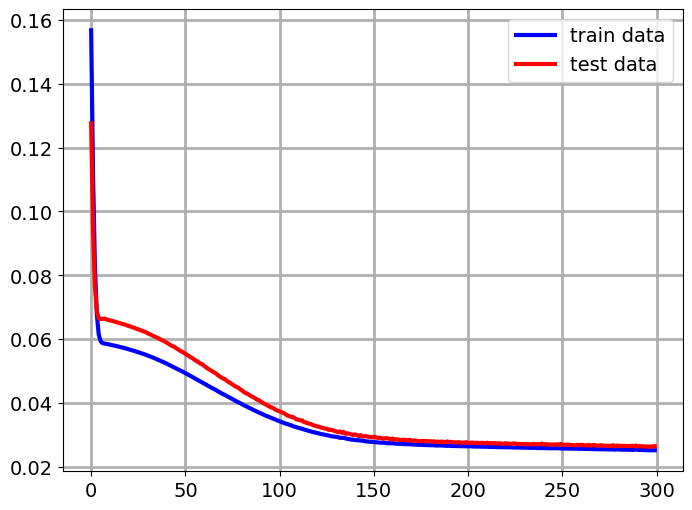

0

In [12]:
model.plot()

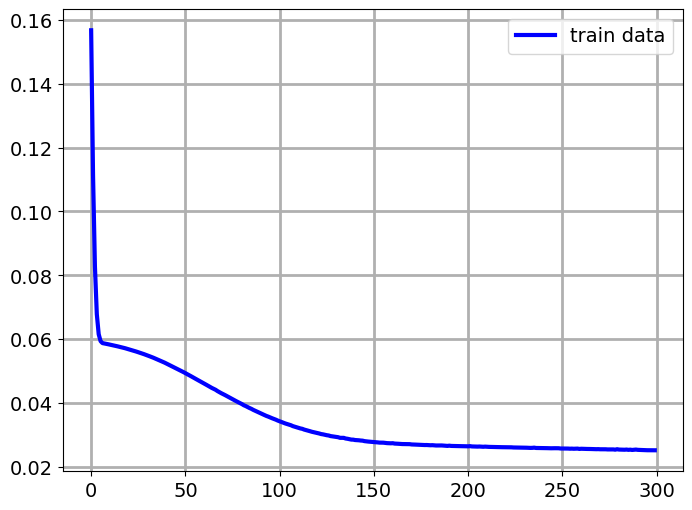

0

In [13]:
model.plot_train()

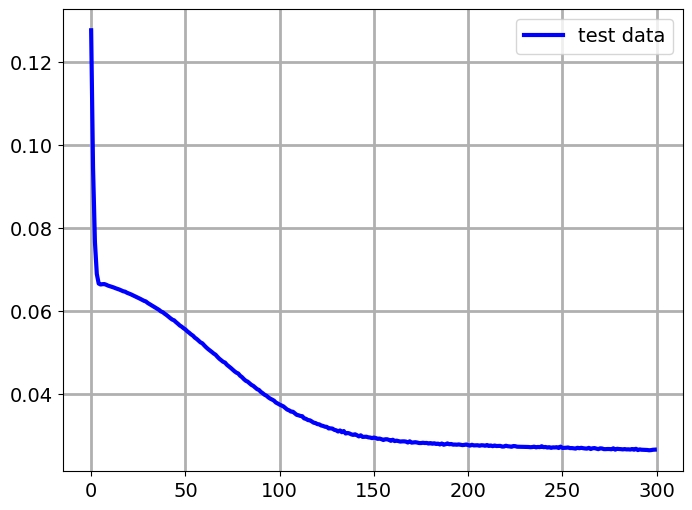

0

In [14]:
model.plot_test()

In [15]:
model.mobius_to_fuzzy()

{(): np.float64(0.0),
 (1,): np.float64(0.004259772598743439),
 (2,): np.float64(0.0011550397612154484),
 (3,): np.float64(0.056044165045022964),
 (4,): np.float64(0.002132269786670804),
 (5,): np.float64(0.003244962077587843),
 (6,): np.float64(0.001933518797159195),
 (1, 2): np.float64(0.045140443835407495),
 (1, 3): np.float64(0.08891399577260017),
 (1, 4): np.float64(0.2169094041455537),
 (1, 5): np.float64(0.11909649102017283),
 (1, 6): np.float64(0.3443389944732189),
 (2, 3): np.float64(0.10134157771244645),
 (2, 4): np.float64(0.1919390948023647),
 (2, 5): np.float64(0.10809470154345036),
 (2, 6): np.float64(0.2552909501828253),
 (3, 4): np.float64(0.06413453980349004),
 (3, 5): np.float64(0.11047194851562381),
 (3, 6): np.float64(0.0660296818241477),
 (4, 5): np.float64(0.1218384641688317),
 (4, 6): np.float64(0.37635973771102726),
 (5, 6): np.float64(0.0819876859895885),
 (1, 2, 3): np.float64(0.17393703991547227),
 (1, 2, 4): np.float64(0.4464418606366962),
 (1, 2, 5): np.flo

In [16]:
model.shapley()

{(1,): 0.3685550279915333,
 (2,): 0.3153634802438319,
 (3,): 0.12501684273593128,
 (4,): 0.44907348649576306,
 (5,): 0.2331148195080459,
 (6,): 0.5256851422600448}

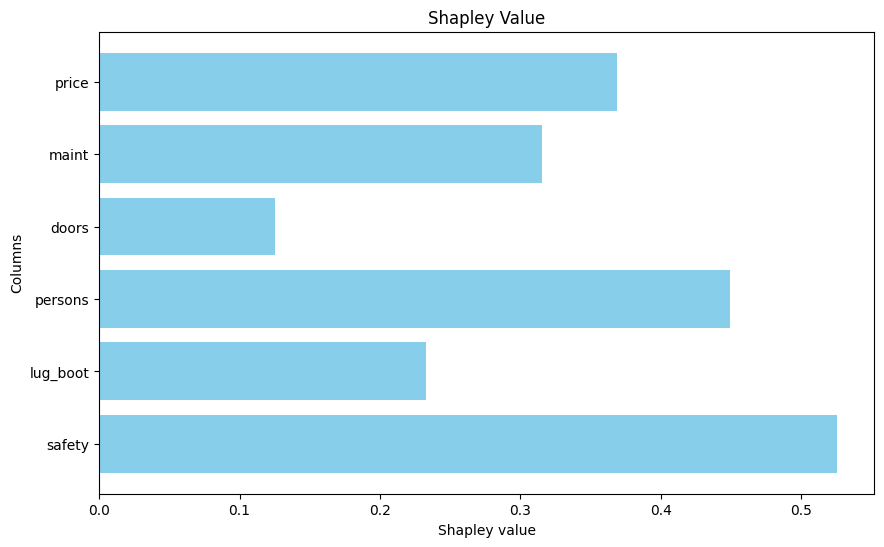

0

In [17]:
model.shapley_plot(X.columns)

In [ ]:
# model.param_exp()